In [3]:
# nltk data download (한 번만 하면 됨)
import nltk
#nltk.download()

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re

import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.text import Tokenizer

from scipy.spatial.distance import euclidean

from gensim.matutils import hellinger, jaccard
from gensim.models.word2vec import Word2Vec

tokenizer = TreebankWordTokenizer()
lemmatizer = WordNetLemmatizer()
scaler = MinMaxScaler()

In [5]:
# 사용자 정의 함수들

class LemmatizationWithPOSTagger(object):
    def __init__(self):
        pass
    def get_wordnet_pos(self,treebank_tag):
        """
        return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
        """
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            # As default pos in lemmatization is Noun
            return wordnet.NOUN

    def pos_tag(self,tokens):
        # find the pos tagginf for each tokens [('What', 'WP'), ('can', 'MD'), ('I', 'PRP') ....
        pos_tokens = [nltk.pos_tag(token) for token in tokens]

        # lemmatization using pos tagg   
        # convert into feature set of [('What', 'What', ['WP']), ('can', 'can', ['MD']), ... ie [original WORD, Lemmatized word, POS tag]
        pos_tokens = [ [(word, lemmatizer.lemmatize(word,self.get_wordnet_pos(pos_tag)), [pos_tag]) for (word,pos_tag) in pos] for pos in pos_tokens]
        return pos_tokens

# 데이터 불러오기

In [6]:
df = pd.read_csv('C:/Users/Euisung/Desktop/Artech/Graduation/dataset/dataset_cognitivescience_01_TiAbs.csv', encoding='latin')
df[0:10]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Title     255 non-null    object 
 1   Abstract  235 non-null    object 
 2   Label     11 non-null     float64
dtypes: float64(1), object(2)
memory usage: 6.1+ KB


In [7]:
# null 체크 & 제거
print(df.isnull().sum())
num_label = df['Label'].sum()  # including된 논문 개수

df_nullout = df[['Title', 'Abstract']].dropna().copy() # 파생 dataFrame 메모리 할당
df_nullout['Text'] = df_nullout[['Title', 'Abstract']].apply(lambda x: '. '.join(x), axis=1) # Titel + Abstract 합친 열 생성
df_nullout['Label'] = df['Label']
df_nullout['Label'].fillna(0, inplace=True)
df_nullout.reset_index(drop=True, inplace=True) # 행 index 리셋 (Null로 지운 행이 번호 상 빠져있기 때문)
print(df_nullout)
# print(df_nullout.iloc[215])
indices = pd.Series(df_nullout.index, index=df_nullout['Title'])

texts = df_nullout.get('Text')
texts[0] # doc2vec사용 가능 포멧

Title         0
Abstract     20
Label       244
dtype: int64
                                                 Title  \
0    About the effectiveness of telehealth procedur...   
1    Acceptability of virtual reality interoceptive...   
2    Acute anxiolytic effects of quetiapine during ...   
3    Age-dependent modulation of sensory reweightin...   
4    Allocentric lock in anorexia nervosa: New evid...   
..                                                 ...   
230  VirtualPhobia: A Model for Virtual Therapy of ...   
231  Visualizing ideal self vs. actual self through...   
232  Wii Fit is effective in women with bone loss c...   
233  Working alliance inventory applied to virtual ...   
234  Yohimbine enhancement of exposure therapy for ...   

                                              Abstract  \
0    Use of new technologies for psychological trea...   
1    Interoceptive exposure (IE) is a standard comp...   
2    Anxiety disorders are among the most frequent ...   
3    Older

'About the effectiveness of telehealth procedures in psychological treatments.. Use of new technologies for psychological treatment is currently experiencing considerable growth. From an experimental point of view, the greatest developments have concerned use of virtual reality and online programs. The present study analyzes both types of resources, with a special focus on Internet-based psychological treatment programs. The development of virtual reality has mainly been aimed at treating phobias. This resource has shown similar effectiveness to traditional treatments and even greater clinical efficacy in some cases. Internet-based psychological treatment has had a broader development, although it has been particularly applied to anxiety and depression problems. Systematic reviews and meta-analyses have shown a great heterogeneity of studies; however, some programs have proven to be effective, particularly when compared to a group without treatment and when such programs involve contac

# Preprocessing

In [8]:
paragraphs = []
for text in texts.values:
    paragraphs.append(sent_tokenize(text))
    
paragraphs[0]

['About the effectiveness of telehealth procedures in psychological treatments.. Use of new technologies for psychological treatment is currently experiencing considerable growth.',
 'From an experimental point of view, the greatest developments have concerned use of virtual reality and online programs.',
 'The present study analyzes both types of resources, with a special focus on Internet-based psychological treatment programs.',
 'The development of virtual reality has mainly been aimed at treating phobias.',
 'This resource has shown similar effectiveness to traditional treatments and even greater clinical efficacy in some cases.',
 'Internet-based psychological treatment has had a broader development, although it has been particularly applied to anxiety and depression problems.',
 'Systematic reviews and meta-analyses have shown a great heterogeneity of studies; however, some programs have proven to be effective, particularly when compared to a group without treatment and when suc

In [9]:
stop_words = stopwords.words('english')
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https',
    'et', 'al', 'figure', 'rights', 'reserved', 'permission', 'used',
    'using', 'license', 'fig', 'fig.', 'al.', 'elsevier', 'pmc', 'www',
    'study'
]

for w in custom_stop_words:
    if w not in stop_words:
        stop_words.append(w)

In [10]:
lemmatization_using_pos_tagger = LemmatizationWithPOSTagger()

preprocessed_text = []
for i in range(0, len(texts)):
    line = []
    for string in paragraphs[i]:
        normalized_text = re.sub(r"[^a-z]+", " ", string.lower())                 # 텍스트 정규화. 특수문자 제거, 소문자화
        if normalized_text == " " : continue
        tokenized_text = tokenizer.tokenize(normalized_text)                           # 텍스트 토큰화
        stopped_text = [token for token in tokenized_text if token not in stop_words]  # 불용어처리
        under2_text = [token for token in stopped_text if (len(token)>2 or ('vr' in token))]
        line.append(under2_text)
    preprocessed_text.append(line)

lemmatized_pos_text = []
for i in range(0, len(preprocessed_text)):
    lemmatized_pos_text.append(lemmatization_using_pos_tagger.pos_tag(preprocessed_text[i]))        # pos_tag 방식으로 표제어추출
lemmatized_pos_text[0][0][0]
# len(lemmatized_pos_text)

('effectiveness', 'effectiveness', ['NN'])

In [11]:
token_list = []
for i in range(0, len(lemmatized_pos_text)):
    line = []
    for j in range(0, len(lemmatized_pos_text[i])):
        token = []
        for k in range(0, len(lemmatized_pos_text[i][j])):
            if (len(lemmatized_pos_text[i][j][k][1])>2 or ('vr' in lemmatized_pos_text[i][j][k][1])):
#                 print(lemmatized_pos_text[i][j][k][1])
                token.append(lemmatized_pos_text[i][j][k][1])
        line.append(token)
    token_list.append(line)

token_list[0]
len(token_list)

# token_list -> 정규화, 토큰화, 불용어, 표제어추출까지 됨

235

In [12]:
token_forTF = []
for i in range(0, len(token_list)):
    line = []
    for j in range(0, len(token_list[i])):
        line.append(" ".join(token_list[i][j]))
    token_forTF.append(" ".join(line))
token_forTF  # list 형식, 한 셀에 패러그래프 그대로 들어가있음

token_word = [tokenizer.tokenize(token) for token in token_forTF]  # list 형식, 한 셀에 패러그래프 token화 된 거 들어 있음
# token_word
# token_forTF
len(token_forTF)

235

Parser -> scispacy 기반

In [13]:
import string

punctuations = string.punctuation

In [14]:
from tqdm import tqdm
import scispacy
import spacy
import en_core_sci_lg

parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 700000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [15]:
tqdm.pandas()
df_nullout['Preprocessed_text'] = df_nullout['Text'].progress_apply(spacy_tokenizer)

C:\Users\Euisung\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 235/235 [00:04<00:00, 53.34it/s]


count    235.000000
mean     209.157447
std       81.317915
min       45.000000
25%      161.000000
50%      207.000000
75%      248.500000
max      805.000000
Name: abstract_word_count, dtype: float64

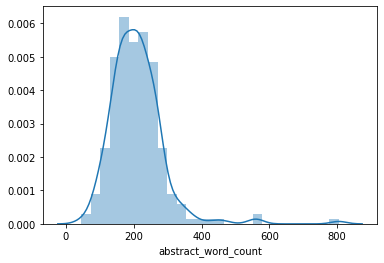

In [16]:
import seaborn as sns

df_nullout['abstract_word_count'] = df_nullout['Text'].apply(lambda x: len(x.strip().split()))

sns.distplot(df_nullout['abstract_word_count'])
df_nullout['abstract_word_count'].describe()

In [17]:
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [18]:
scispacy_text = df_nullout['Preprocessed_text'].values
X_t = vectorize(scispacy_text, 300)
X_t.shape

(235, 300)

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X_t.toarray())
X_reduced.shape

# scaler = StandardScaler()
# scaler.fit_transform(X_reduced)

(235, 142)

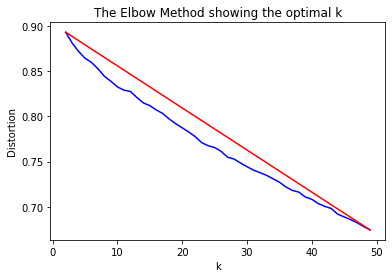

In [20]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X_t.shape[0])
    #print('Found distortion for {} clusters'.format(k))
    

X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [49]:
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df_nullout['y'] = y_pred
# print(len(df_nullout[df_nullout['y'].isin(['1'])]))
is_Label = df_nullout[df_nullout['Label'].isin(['1'])]
sub_df = pd.DataFrame(is_Label)

print('총 문서 수 : %d' % len(df_nullout))
print('예측값 분포')
print(df_nullout['y'].value_counts())
print('Label=1, 예측값 분포')
print(sub_df['y'].value_counts())
df_nullout[df_nullout['Label'].isin(['1'])]
# print(df_nullout[df_nullout['y'].isin(['2'])])

총 문서 수 : 235
예측값 분포
0    123
1    112
Name: y, dtype: int64
Label=1, 예측값 분포
1    11
Name: y, dtype: int64


,Title,Abstract,Text,Label,Preprocessed_text,abstract_word_count,y,Similarity
30,Cognitive-behavioral treatment and antidepressants combined with virtual reality exposure for pa...,In this study we compared the efficacy of virtual reality exposure combined with cognitive-behav...,Cognitive-behavioral treatment and antidepressants combined with virtual reality exposure for pa...,1.0,cognitive-behavioral treatment antidepressant combine virtual reality exposure patient chronic a...,177,1,0.114094
31,The combined use of virtual reality exposure in the treatment of agoraphobia.,Introduction. This study compares the differential efficacy of three groups of treatments for ag...,The combined use of virtual reality exposure in the treatment of agoraphobia.. Introduction. Thi...,1.0,combine use virtual reality exposure treatment agoraphobia .. introduction compare differential ...,145,1,0.133858
36,A controlled study of agoraphobia and the independent effect of virtual reality exposure therapy.,OBJECTIVES: Past controlled clinical trials centred on virtual reality exposure therapy (VRET) f...,A controlled study of agoraphobia and the independent effect of virtual reality exposure therapy...,1.0,control agoraphobia independent effect virtual reality exposure therapy .. objectives past contr...,163,1,0.150685
61,"Effectiveness of cognitive behavioral therapy integrated with systematic desensitization, cognit...",The purpose of the research was to compare the effectiveness of the following treatment methods ...,"Effectiveness of cognitive behavioral therapy integrated with systematic desensitization, cognit...",1.0,effectiveness cognitive behavioral therapy integrate systematic desensitization cognitive behavi...,207,1,0.207407
81,Exposure to virtual social interactions in the treatment of social anxiety disorder: A randomize...,This randomized controlled trial investigated the efficacy of a stand-alone virtual reality expo...,Exposure to virtual social interactions in the treatment of social anxiety disorder: A randomize...,1.0,exposure virtual social interaction treatment social anxiety disorder randomize control trial .....,224,1,0.211921
111,In Vivo versus augmented reality exposure in the treatment of small animal phobia: A randomized ...,"Although in vivo exposure is the treatment of choice for specific phobias, some acceptability pr...",In Vivo versus augmented reality exposure in the treatment of small animal phobia: A randomized ...,1.0,vivo versus augment reality exposure treatment small animal phobia randomize control trial .. al...,284,1,0.145455
134,One session treatment of cognitive and behavioral therapy and virtual reality for social and spe...,This randomized clinical trial aimed to investigate the efficacy of one session treatment of VRC...,One session treatment of cognitive and behavioral therapy and virtual reality for social and spe...,1.0,one session treatment cognitive behavioral therapy virtual reality social specific phobia prelim...,160,1,0.170543
208,Virtual reality compared with in vivo exposure in the treatment of social anxiety disorder: a th...,BackgroundPeople with social anxiety disorder (SAD) fear social interactions and may be reluctan...,Virtual reality compared with in vivo exposure in the treatment of social anxiety disorder: a th...,1.0,virtual reality compare vivo exposure treatment social anxiety disorder three-arm randomise cont...,216,1,0.232394
214,Virtual reality exposure therapy does not provide any additional value in agoraphobic patients: ...,Background: A number of studies have demonstrated the efficacy of virtual reality exposure thera...,Virtual reality exposure therapy does not provide any additional value in agoraphobic patients: ...,1.0,virtual reality exposure therapy doe provide additional value agoraphobic patient randomize cont...,271,1,0.209150
215,Virtual reality exposure therapy for social anxiety disorder: a randomized controlled trial.,OBJECTIVE: This is the first randomized t

In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X_t.toarray())

[t-SNE] Computing 234 nearest neighbors...
[t-SNE] Indexed 235 samples in 0.000s...
[t-SNE] Computed neighbors for 235 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 235 / 235
[t-SNE] Mean sigma: 0.424400
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.769211
[t-SNE] KL divergence after 1000 iterations: 0.511878


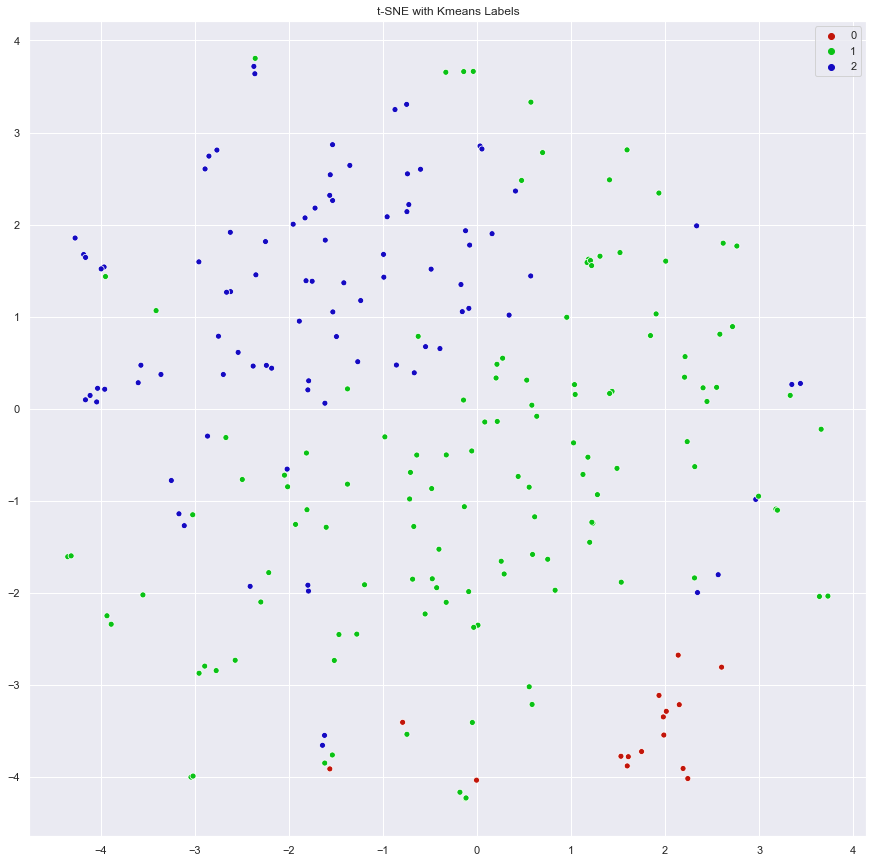

In [23]:
%matplotlib inline

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(k, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

In [24]:
vectorizers = []

for ii in range(0, k):
    # creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words=stop_words, lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))


In [25]:
vectorizers[0]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}',
                tokenizer=None, vocabulary=None)

In [26]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df_nullout.loc[df_nullout['y'] == current_cluster, 'Preprocessed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [27]:
len(vectorized_data)

3

In [28]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 10

lda_models = []
for ii in range(0, k):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]
len(lda_models)

3

In [29]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))
len(clusters_lda_data)

3

In [30]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [31]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [32]:
all_keywords[0]

['virtual',
 'balance',
 'participant',
 'associate',
 'physical',
 'old',
 'postural',
 'adult',
 'elderly',
 'group',
 'significant',
 'train',
 'show',
 'control',
 'reality',
 'pilot',
 'result',
 'effect']

In [31]:
excel_keyword= pd.DataFrame(all_keywords)
excel_keyword.to_excel(excel_writer='topics1.xlsx')

## 2nd step-wise clustering

In [32]:
cluster_list = {2}
is_stepwise = df_nullout['y'].isin(cluster_list)
is_stepwise
df_second_step = df_nullout[is_stepwise].reset_index().drop('index', axis=1)
df_second_step

,Title,Abstract,Text,Label,Preprocessed_text,abstract_word_count,y
0,Acute anxiolytic effects of quetiapine during ...,Anxiety disorders are among the most frequent ...,Acute anxiolytic effects of quetiapine during ...,0.0,acute anxiolytic effect quetiapine virtual rea...,270,2
1,Auditory and visual 3D virtual reality therapy...,Background: Subjective tinnitus (ST) is a freq...,Auditory and visual 3D virtual reality therapy...,0.0,auditory visual 3d virtual reality therapy new...,249,2
2,Augmentation of cognitive and behavioural ther...,Background: A significant number of patients w...,Augmentation of cognitive and behavioural ther...,0.0,augmentation cognitive behavioural therapy cbt...,805,2
3,Augmentation of exposure therapy with post-ses...,BACKGROUND: Pre-session administration of d-cy...,Augmentation of exposure therapy with post-ses...,0.0,augmentation exposure therapy post-session adm...,257,2
4,Baseline psychophysiological and cortisol reac...,Baseline cue-dependent physiological reactivit...,Baseline psychophysiological and cortisol reac...,0.0,baseline psychophysiological cortisol reactivi...,256,2
...,...,...,...,...,...,...,...
86,Virtual Reality Exposure Training for Musician...,Music performance anxiety affects numerous mus...,Virtual Reality Exposure Training for Musician...,0.0,virtual reality exposure training musicians ef...,197,2
87,Virtual reality exposure using three-dimension...,Objective: To test a potential treatment for s...,Virtual reality exposure using three-dimension...,0.0,virtual reality exposure use three-dimensional...,153,2
88,Virtual reality in the treatment of mental dis...,Virtual reality is a media allowing users to i...,Virtual reality in the treatment of mental dis...,0.0,virtual reality treatment mental disorder .. v...,190,2
89,A virtual reality-integrated program for impro...,Background and objectives: Social skills train...,A virtual reality-integrated program for impro...,0.0,virtual reality-integrated program improve soc...,260,2


In [33]:
scispacy_text_2 = df_second_step['Preprocessed_text'].values
X_t2 = vectorize(scispacy_text_2, 300)
X_t2.shape

(91, 300)

In [34]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=0.95, random_state=42)
X_reduced2= pca.fit_transform(X_t2.toarray())
X_reduced2.shape

# scaler = StandardScaler()
# scaler.fit_transform(X_reduced)

(91, 70)

In [39]:
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_t2)
df_second_step['y'] = y_pred
# print(len(df_nullout[df_nullout['y'].isin(['1'])]))
is_Label = df_second_step[df_second_step['Label'].isin(['1'])]
sub_df = pd.DataFrame(is_Label)

print('총 문서 수 : %d' % len(df_second_step))
print('예측값 분포')
print(df_second_step['y'].value_counts())
print('Label=1, 예측값 분포')
print(sub_df['y'].value_counts())
df_second_step[df_second_step['Label'].isin(['1'])]
# print(df_nullout[df_nullout['y'].isin(['2'])])

총 문서 수 : 91
예측값 분포
0    59
1    32
Name: y, dtype: int64
Label=1, 예측값 분포
0    10
1     1
Name: y, dtype: int64


,Title,Abstract,Text,Label,Preprocessed_text,abstract_word_count,y
9,Cognitive-behavioral treatment and antidepress...,In this study we compared the efficacy of virt...,Cognitive-behavioral treatment and antidepress...,1.0,cognitive-behavioral treatment antidepressant ...,177,0
10,The combined use of virtual reality exposure i...,Introduction. This study compares the differen...,The combined use of virtual reality exposure i...,1.0,combine use virtual reality exposure treatment...,145,0
11,A controlled study of agoraphobia and the inde...,OBJECTIVES: Past controlled clinical trials ce...,A controlled study of agoraphobia and the inde...,1.0,control agoraphobia independent effect virtual...,163,0
19,Effectiveness of cognitive behavioral therapy ...,The purpose of the research was to compare the...,Effectiveness of cognitive behavioral therapy ...,1.0,effectiveness cognitive behavioral therapy int...,207,0
30,Exposure to virtual social interactions in the...,This randomized controlled trial investigated ...,Exposure to virtual social interactions in the...,1.0,exposure virtual social interaction treatment ...,224,0
41,In Vivo versus augmented reality exposure in t...,Although in vivo exposure is the treatment of ...,In Vivo versus augmented reality exposure in t...,1.0,vivo versus augment reality exposure treatment...,284,1
49,One session treatment of cognitive and behavio...,This randomized clinical trial aimed to invest...,One session treatment of cognitive and behavio...,1.0,one session treatment cognitive behavioral the...,160,0
78,Virtual reality compared with in vivo exposure...,BackgroundPeople with social anxiety disorder ...,Virtual reality compared with in vivo exposure...,1.0,virtual reality compare vivo exposure treatmen...,216,0
82,Virtual reality exposure therapy does not prov...,Background: A number of studies have demonstra...,Virtual reality exposure therapy does not prov...,1.0,virtual reality exposure therapy doe provide a...,271,0
83,Virtual reality exposure therapy for social an...,OBJECTIVE: This is the first randomized trial ...,Virtual reality exposure therapy for social an...,1.0,virtual reality exposure therapy social anxiet...,255,0


# Interactive plotting

클러스터별 키워드 추출

In [122]:
f=open('topics.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [98]:
# required libraries for plot
from call_backs import input_callback, selected_code  # file with customJS callbacks for bokeh
                                                      # github.com/MaksimEkin/COVID19-Literature-Clustering/blob/master/lib/call_backs.py
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, widgetbox, row, layout
from bokeh.layouts import column

In [99]:
import os

topic_path = 'topics.txt'
with open(topic_path) as f:
    topics = f.readlines()

In [100]:
# show on notebook
output_notebook()
# target labels
y_labels = y_pred

# data sources
source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= df_nullout['Title'],
    Labels = df_nullout['Label'],
    clusters = df_nullout['y'],
#     authors = df['authors'],
#     journal = df['journal'],
#     abstract = df['abstract_summary'],
    labels = ["C-" + str(x) for x in y_labels],
#     links = df['doi']
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Label", "@Labels{safe}"),
    ("Cluster", "@clusters{safe}"),
#     ("Author(s)", "@authors{safe}"),
#     ("Journal", "@journal"),
#     ("Abstract", "@abstract{safe}"),
#     ("Link", "@links")
],
point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
plot = figure(plot_width=1200, plot_height=850, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'], 
           title="Clustering of the COVID-19 Literature with t-SNE and K-Means", 
           toolbar_location="above")

# plot settings
plot.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend = 'labels')
plot.legend.background_fill_alpha = 0.6

Loading BokehJS ...

In [101]:
text_banner = Paragraph(text= 'Keywords: Slide to specific cluster to see the keywords.', height=45)
input_callback_1 = input_callback(plot, source, text_banner, topics)

# currently selected article
div_curr = Div(text="""Click on a plot to see the link to the article.""",height=150)
callback_selected = CustomJS(args=dict(source=source, current_selection=div_curr), code=selected_code())
taptool = plot.select(type=TapTool)
taptool.callback = callback_selected

# WIDGETS
slider = Slider(start=0, end=20, value=20, step=1, title="Cluster #", callback=input_callback_1)
keyword = TextInput(title="Search:", callback=input_callback_1)

# pass call back arguments
input_callback_1.args["text"] = keyword
input_callback_1.args["slider"] = slider

In [102]:
# STYLE
slider.sizing_mode = "stretch_width"
slider.margin=15

keyword.sizing_mode = "scale_both"
keyword.margin=15

div_curr.style={'color': '#BF0A30', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
div_curr.sizing_mode = "scale_both"
div_curr.margin = 20

text_banner.style={'color': '#0269A4', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
text_banner.sizing_mode = "scale_both"
text_banner.margin = 20

plot.sizing_mode = "scale_both"
plot.margin = 5

r = row(div_curr,text_banner)
r.sizing_mode = "stretch_width"

In [38]:
# LAYOUT OF THE PAGE
l = layout([
    [slider, keyword],
    [text_banner],
    [div_curr],
    [plot],
])
l.sizing_mode = "scale_both"

# show
output_file('t-sne_covid-19_interactive.html')
show(l)

# 횟수 기반 검색

정수 인코딩

In [33]:
tokenizer_keras = Tokenizer()

tokenizer_keras.fit_on_texts(token_forTF)
token_indexing = tokenizer_keras.texts_to_sequences(token_forTF)  # 상위빈도수 적용x
token_indexing
len(token_indexing)

235

문서 단어 행렬 (Document-Term Matrix, DTM)

In [34]:

cVector = CountVectorizer(stop_words=None, max_features=None, lowercase=False, ngram_range=(1,1))

DTM_vector = cVector.fit_transform(token_forTF).toarray()   # =BOW
# len(DTM_vector)
DTM_vector.shape

(235, 3594)

TF-IDF

In [35]:

tfidfVector = TfidfVectorizer(stop_words=None, ngram_range=(1,1)) # ngram_range: (1,1) unigram, (2,2) bigram
tfidf_matrix = tfidfVector.fit_transform(token_forTF).toarray()
tfidf_matrix.shape
tfidf_matrix_m = tfidf_matrix-tfidf_matrix.mean()
tfidf_matrix_m.shape
# print(tfidfVector.transform(token_forTF).toarray())
# print(tfidfVector.vocabulary_)
# token_forTF

(235, 3594)

LDA

In [36]:
from sklearn.decomposition import LatentDirichletAllocation

NUM_TOPICS = 5   # 만들 토필 수 지정
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, random_state=np.random.RandomState(10))
lda_vector = lda.fit_transform(DTM_vector)

lda_vector.shape
# len(lda_vector)

(235, 5)

truncated SVD

In [37]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=5, n_iter=100)
svd_vector = svd.fit_transform(tfidf_matrix_m)
# svd_vector = pd.DataFrame(svd_vector)
svd_vector

array([[ 0.22107219,  0.01590442, -0.16628801, -0.03941185,  0.05159315],
       [ 0.29249371, -0.03032733, -0.1403613 , -0.07332448, -0.0146883 ],
       [ 0.19187674, -0.07620144,  0.01748328, -0.00486139, -0.01026394],
       ...,
       [ 0.10925631, -0.06070623,  0.14024768, -0.11832945,  0.44822249],
       [ 0.11663929,  0.01124245, -0.02683234, -0.04419143, -0.01605807],
       [ 0.30080385, -0.2130708 ,  0.09702119,  0.10408969, -0.00397035]])

# 유사도 검색

유클리디안 거리

In [38]:
## seed literature 제목입력해서 행 값 찾기
# print(df_nullout.loc[df_nullout['Title'] == 'A virtual reality application in role-plays of social skills training for schizophrenia: a randomized, controlled trial'].index)
seed_idxnum = df_nullout.loc[df_nullout['Title'] == 'Virtual reality exposure therapy for social anxiety disorder: a randomized controlled trial.'].index[0]
print('seed number :',seed_idxnum)

seed number : 215


In [39]:
def get_recommendation_euclidean(title, n, vector_form=tfidf_matrix_m):
    '''title: 논문제목, n: 몇 개 까지 띄울지'''
    idx = indices[title]
    euclidean_sim = []
    for i in range(0, len(vector_form)):
        euclidean_sim.append(0+(euclidean(vector_form[idx], vector_form[i])))
    
    # euclidean distance가 1이상 값이 나와서 0~1로 nomalization
    temp = euclidean_sim[idx]
    del euclidean_sim[idx]     # normalization 하기위해 동일 문서에 대한 값 제거했다가 추가
    euclidean_sim = scaler.fit_transform(np.reshape(euclidean_sim, (-1,1))).flatten().tolist()
    euclidean_sim.insert(idx, temp)
    euclidean_sim = [1-i for i in euclidean_sim] # distance -> similarity
    euclidean_scores = list(enumerate(euclidean_sim))
    
    df_euclisim = df_nullout
    df_euclisim['Similarity'] = [i[1] for i in euclidean_scores]
    euc_scores_sort = sorted(euclidean_scores, key=lambda x: x[1], reverse=True)
    euc_scores_sort = euc_scores_sort[0:n+1]
    article_indices = [i[0] for i in euc_scores_sort]
    
    return df_euclisim[['Title', 'Label', 'Similarity']].iloc[article_indices]

In [40]:
df_eucl = get_recommendation_euclidean(df_nullout['Title'].loc[seed_idxnum],
                                      150).reset_index()

print(len(df_eucl[df_eucl['Label'].isin(['1'])]))
df_eucl[df_eucl['Label'].isin(['1'])].sort_values(by='index')
# df_eucl.head()

11


,index,Title,Label,Similarity
16,30,Cognitive-behavioral treatment and antidepress...,1.0,0.601643
14,31,The combined use of virtual reality exposure i...,1.0,0.641218
42,36,A controlled study of agoraphobia and the inde...,1.0,0.458543
20,61,Effectiveness of cognitive behavioral therapy ...,1.0,0.543875
2,81,Exposure to virtual social interactions in the...,1.0,0.951354
7,111,In Vivo versus augmented reality exposure in t...,1.0,0.722884
17,134,One session treatment of cognitive and behavio...,1.0,0.596737
0,208,Virtual reality compared with in vivo exposure...,1.0,1.000000
8,214,Virtual reality exposure therapy does not prov...,1.0,0.721483
1,215,Virtual reality exposure therapy for social an...,1.0,1.000000


코사인 유사도

In [41]:
def get_recommendation(title, n, tfidf_matrix_m=tfidf_matrix_m):
    '''title: 논문제목, n: 몇 개 까지 띄울지'''
    cosine_sim = cosine_similarity(tfidf_matrix_m, tfidf_matrix_m)
    
    idx = indices[title]
#     print(cosine_sim)
    sim_scores = list(enumerate(cosine_sim[idx]))
#     print(sim_scores)
    df_cossim = df_nullout
    df_cossim['Similarity'] = [i[1] for i in sim_scores]
    sim_scores_sort = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores_sort = sim_scores_sort[0:n+1]
    article_indices = [i[0] for i in sim_scores_sort]
#     print(article_indices)
#     article_indices = article_indices[1:11]
#     print(article_indices)
    
#     return df_nullout['Title'].iloc[article_indices]
    return df_cossim[['Title', 'Label', 'Similarity']].iloc[article_indices]

In [42]:
'''get_recommendation에 논문제목(title) 넣어주어야함'''
df_tfidf = pd.DataFrame(get_recommendation(df_nullout['Title'].loc[seed_idxnum], 
                                           250)).reset_index()

pd.set_option('display.max.colwidth', 100)

print(len(df_tfidf[df_tfidf['Label'].isin(['1'])]))
df_tfidf[df_tfidf['Label'].isin(['1'])].sort_values(by='index')

# cosine_similarity(DTM_vector[215], DTM_vector[208])

11


,index,Title,Label,Similarity
16,30,Cognitive-behavioral treatment and antidepressants combined with virtual reality exposure for pa...,1.0,0.214255
14,31,The combined use of virtual reality exposure in the treatment of agoraphobia.,1.0,0.231382
41,36,A controlled study of agoraphobia and the independent effect of virtual reality exposure therapy.,1.0,0.163773
19,61,"Effectiveness of cognitive behavioral therapy integrated with systematic desensitization, cognit...",1.0,0.195501
2,81,Exposure to virtual social interactions in the treatment of social anxiety disorder: A randomize...,1.0,0.334183
8,111,In Vivo versus augmented reality exposure in the treatment of small animal phobia: A randomized ...,1.0,0.256213
17,134,One session treatment of cognitive and behavioral therapy and virtual reality for social and spe...,1.0,0.213466
1,208,Virtual reality compared with in vivo exposure in the treatment of social anxiety disorder: a th...,1.0,0.350211
7,214,Virtual reality exposure therapy does not provide any additional value in agoraphobic patients: ...,1.0,0.256743
0,215,Virtual reality exposure therapy for social anxiety disorder: a randomized controlled trial.,1.0,1.000000


Hellinger 유사도

In [43]:
def get_recommendation_hellinger(title, n, lda_result=lda_vector):
    idx = indices[title]
    hellinger_sim = []
    for i in range(0, len(lda_result)):
        hellinger_sim.append(1-(hellinger(lda_result[idx], lda_result[i])))

    hellinger_scores = list(enumerate(hellinger_sim))
#     print(hellinger_scores)
    df_hellsim = df_nullout
    df_hellsim['Similarity'] = [i[1] for i in hellinger_scores]
    hell_scores_sort = sorted(hellinger_scores, key=lambda x: x[1], reverse=True)
    hell_scores_sort = hell_scores_sort[0:n+1]
    article_indices = [i[0] for i in hell_scores_sort]
    
    return df_hellsim[['Title', 'Label', 'Similarity']].iloc[article_indices]

In [44]:
df_hell = get_recommendation_hellinger(df_nullout['Title'].loc[seed_idxnum], 
                                       260).reset_index()

print(len(df_hell[df_hell['Label'].isin(['1'])]))
df_hell[df_hell['Label'].isin(['1'])].sort_values(by='index')

11


,index,Title,Label,Similarity
65,30,Cognitive-behavioral treatment and antidepressants combined with virtual reality exposure for pa...,1.0,0.675888
14,31,The combined use of virtual reality exposure in the treatment of agoraphobia.,1.0,0.856066
58,36,A controlled study of agoraphobia and the independent effect of virtual reality exposure therapy.,1.0,0.677228
78,61,"Effectiveness of cognitive behavioral therapy integrated with systematic desensitization, cognit...",1.0,0.674033
88,81,Exposure to virtual social interactions in the treatment of social anxiety disorder: A randomize...,1.0,0.671959
91,111,In Vivo versus augmented reality exposure in the treatment of small animal phobia: A randomized ...,1.0,0.671743
41,134,One session treatment of cognitive and behavioral therapy and virtual reality for social and spe...,1.0,0.679279
6,208,Virtual reality compared with in vivo exposure in the treatment of social anxiety disorder: a th...,1.0,0.929891
92,214,Virtual reality exposure therapy does not provide any additional value in agoraphobic patients: ...,1.0,0.671740
0,215,Virtual reality exposure therapy for social anxiety disorder: a randomized controlled trial.,1.0,1.000000


Jaccard 유사도

In [45]:
def get_recommendation_jaccard(title, n, token_word=token_word):
    idx = indices[title]
    jaccard_sim = []
    for i in range(0, len(token_word)):
        jaccard_sim.append(1-(jaccard(token_word[idx], token_word[i])))

    jaccard_scores = list(enumerate(jaccard_sim))
#     print(hellinger_scores)
    df_jacsim = df_nullout
    df_jacsim['Similarity'] = [i[1] for i in jaccard_scores]
    jac_scores_sort = sorted(jaccard_scores, key=lambda x: x[1], reverse=True)
    jac_scores_sort = jac_scores_sort[0:n+1]
    article_indices = [i[0] for i in jac_scores_sort]
    
    return df_jacsim[['Title', 'Label', 'Similarity']].iloc[article_indices]

In [1]:
df_jacc = get_recommendation_jaccard(df_nullout['Title'].loc[seed_idxnum], 
                                    200).reset_index()

print(len(df_jacc[df_jacc['Label'].isin(['1'])]))
df_jacc[df_jacc['Label'].isin(['1'])].sort_values(by='index')

NameError: name 'get_recommendation_jaccard' is not defined

In [47]:
class Similarity2xlsx:
    def __init__(self, my_dataframe):
#         self.save_dataframe = my_dataframe[my_dataframe['Label'].isin(['1'])].rename_axis('Ranking').reset_index()
        self.my_dataframe = my_dataframe[my_dataframe['Label'].isin(['1'])].rename_axis('Ranking').reset_index()

    def make_columns(self):
        N = len(df_nullout)
        
        df_temp = pd.DataFrame(self.my_dataframe[['Title', 'Ranking', 'Similarity']])
#         df_temp = pd.DataFrame()
        df_temp['N'] = N-1
        df_temp['TP'] = np.arange(len(self.my_dataframe))
        df_temp['FN'] = (len(self.my_dataframe)-1) - df_temp['TP']
        df_temp['FP'] = df_temp['Ranking'] - df_temp['TP']
        df_temp['TN'] = df_temp['N'] - (df_temp['TP']+df_temp['FN']+df_temp['FP'])
        df_temp['Accuracy'] = (df_temp['TP']+df_temp['TN'])/N
        df_temp['Recall'] = df_temp['TP']/(df_temp['TP']+df_temp['FN'])
        df_temp['Precision'] = df_temp['TP']/(df_temp['TP']+df_temp['FP'])
        df_temp['F1_score'] = 2 * ((df_temp['Precision']*df_temp['Recall'])/
                                   (df_temp['Precision']+df_temp['Recall']))
        df_temp['WSS'] = (df_temp['TP']+df_temp['TN'])/df_temp['N'] - (1-df_temp['Recall'])
        return df_temp
    
    def get_csv(self):
        index_df = pd.DataFrame(self.my_dataframe[['index', 'Title']])
        
        df_cos = pd.DataFrame(Similarity2xlsx(df_tfidf).make_columns()).add_suffix('_cos').rename({'Title_cos':'Title'}, axis='columns')
        df_hel = pd.DataFrame(Similarity2xlsx(df_hell).make_columns()).add_suffix('_hel').rename({'Title_hel':'Title'}, axis='columns')
        df_jac = pd.DataFrame(Similarity2xlsx(df_jacc).make_columns()).add_suffix('_jac').rename({'Title_jac':'Title'}, axis='columns')
        df_euc = pd.DataFrame(Similarity2xlsx(df_eucl).make_columns()).add_suffix('_euc').rename({'Title_euc':'Title'}, axis='columns')
        merged_df = df_cos.merge(df_euc).merge(df_hel).merge(df_jac).merge(index_df)
        
        # dataframe에서 'index'열 위치 맨 앞으로
        cols = merged_df.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        merged_df = merged_df[cols].sort_values(by='index')
        
        # 엑셀파일로 저장
        merged_df.to_excel('C:/Users/Euisung/Desktop/Artech/Graduation/dataset/ex.xlsx')
        return merged_df

In [48]:
# 3개 유사도 검색 결과 출력
sim2xlsx = Similarity2xlsx(df_tfidf)
xl_df = sim2xlsx.get_csv()
xl_df.info()

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
Name: TP, dtype: int32
0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
Name: TP, dtype: int32
0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
Name: TP, dtype: int32
0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
Name: TP, dtype: int32
